In [1]:
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from utils_dataset import *
from utils_sampling import *
from utils_models import *
from funcs_model_fit_evaluate import *
from funcs_model_predictions import *

In [2]:
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')
plt.rcParams.update({'font.family': 'arial'})

## Split data into halves

In [3]:
datasetName = 'takahashi2016roesch2009burton2018Valid'
dataValid = pd.read_csv('data/' + datasetName + '.csv')

In [4]:
data1, data2, data12, ratList = [], [], [], []
for rat in dataValid['rat'].unique():
    sessions = list(dataValid.loc[dataValid['rat'] == rat, 'session'].unique())
    if len(sessions) > 1:
        data1.append(dataValid[(dataValid['rat'] == rat) & (dataValid['session'].isin(sessions[:len(sessions)//2]))])
        data2.append(dataValid[(dataValid['rat'] == rat) & (dataValid['session'].isin(sessions[len(sessions)//2:]))])
        data12.append(dataValid[dataValid['rat'] == rat])
        ratList.append(rat)
data1 = pd.concat(data1)
data2 = pd.concat(data2)
data12 = pd.concat(data12)

In [5]:
datasetNameList = ['takahashi2016roesch2009burton2018Valid_1sthalf', 'takahashi2016roesch2009burton2018Valid_2ndhalf', 'takahashi2016roesch2009burton2018Valid']

dataDict = {
    'takahashi2016roesch2009burton2018Valid_1sthalf': data1,
    'takahashi2016roesch2009burton2018Valid_2ndhalf': data2,
    'takahashi2016roesch2009burton2018Valid': data12
}

modelList = ['fourState_full', 'sixState_full', 'hybridValue_full', 'hybridLearning_full']
baselineModel = 'sixState_full'
modelNames = {
    'sixState_full': 'Six-state',
    'fourState_full': 'Four-state',
    'hybridLearning_full': 'Hybrid-learning', 
    'hybridValue_full': 'Hybrid-value',
}

## Model comparison

### Calculate WAIC difference

In [6]:
metrics_group, waicDiff_rat_perTrial, waicDiff_rat_perTrial_se = dict(), dict(), dict()
for datasetName in datasetNameList:
    metrics_group[datasetName], waicDiff_rat_perTrial[datasetName], waicDiff_rat_perTrial_se[datasetName] = calculate_likelihood(datasetName, dataDict[datasetName], baselineModel, modelList)

### Model comparison (WAIC) figure

takahashi2016roesch2009burton2018Valid_1sthalf


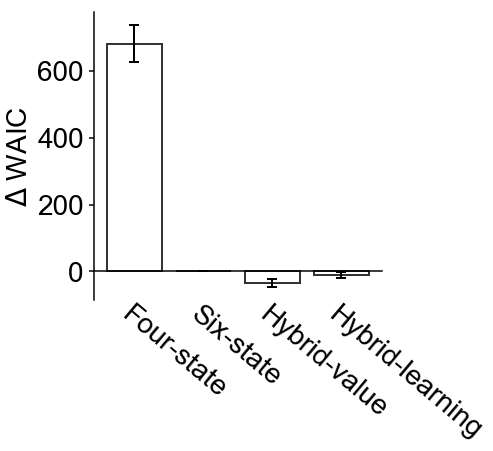

takahashi2016roesch2009burton2018Valid_2ndhalf


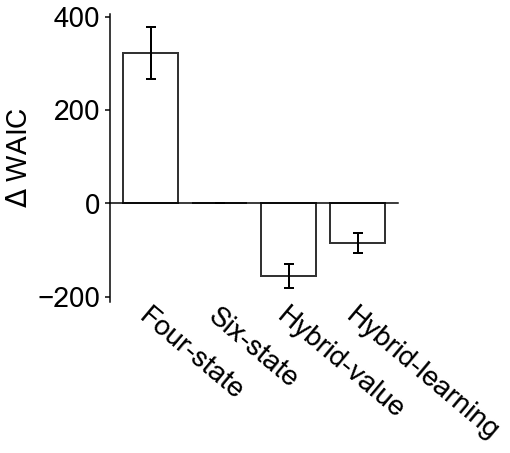

In [7]:
colors_group = {
    'sixState_full':'w',
    'fourState_full':'w',
    'hybridValue_full': 'w',
    'hybridLearning_full':'w'
}

colors_individual = {
    'sixState_full': 'C2',
    'fourState_full': 'C1',
    'hybridValue_full': 'gray',
    'hybridLearning_full':'w'
}

plt.rcParams.update({'font.size': 28})

for datasetName in datasetNameList[:2]:
    print(datasetName)

    fig, ax = plt.subplots(figsize=(4,4))
    iM = 0
    for model in modelList:
        ax.bar(x=iM, height=metrics_group[datasetName].loc['waicDiff', model], alpha=0.8, edgecolor='k', lineWidth=2, color=colors_group[model])
        ax.errorbar(x=iM, y=metrics_group[datasetName].loc['waicDiff', model], yerr=metrics_group[datasetName].loc['waicDiff_se', model], ecolor='k', fmt='None', capsize=5, label=None, elinewidth=2, markeredgewidth=2)
        iM += 1
    sns.despine()
    ax.spines['bottom'].set_position('zero')
    ax.spines['bottom'].set_linewidth(1.5)
    ax.spines['left'].set_linewidth(1.5)
    ax.set_xticks(np.arange(len(modelList))-0.25)
    ax.set_xticklabels([modelNames[model] for model in modelList], rotation=-40, horizontalalignment='left')
    ax.set_xlabel('', fontsize=28)
    ax.set_ylabel(r'$\Delta$ WAIC', fontsize=28)
    ax.tick_params(axis='both', pad=5, labelsize=28)
    ax.tick_params(axis='x', length=0)
    ax.tick_params(axis='x', pad=30 if '1st' in datasetName else 100)
    ax.tick_params(axis='y', direction='out', length=5, width=1.5)
    fig.subplots_adjust(left=0, bottom=0, right=1, top=1)
    plt.show()

## 1st vs 2nd half

### $\Delta$WAIC between hybrid-value and six-state

In [8]:
half1 = waicDiff_rat_perTrial[datasetNameList[0]]
half2 = waicDiff_rat_perTrial[datasetNameList[1]]
overall = waicDiff_rat_perTrial[datasetNameList[2]]
model = 'hybridValue_full'
df_waic = pd.DataFrame.from_dict(dict(zip(['rat','overall', 'half1', 'half2', 'diff'],
                                     [ratList, overall[model].values, half1[model].values, half2[model].values, half2[model].values - half1[model].values])))

In [9]:
plt.rcParams.update({'font.size': 20})

[[<matplotlib.axis.YTick at 0x7f98f4186f28>,

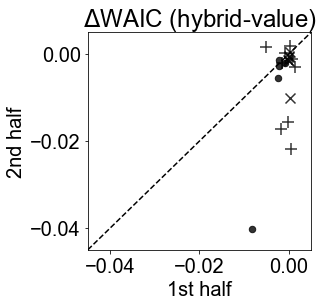

In [10]:
fig, ax = plt.subplots(figsize=(4,4))
for dataset in datasets:
    sns.regplot(x='half1', y='half2', data=df_waic[df_waic['rat'].isin(dataset2rat[dataset])],
                color='k', fit_reg=False, marker=dataset2marker[dataset], scatter_kws={'s':100*ratio_s[dataset]}, label=dataset_labels[dataset])
ax.plot([-0.045, 0.005], [-0.045, 0.005], 'k--')
ax.set(xlim=[-0.045, 0.005], ylim=[-0.045, 0.005])
ax.set(xlabel='1st half', ylabel='2nd half', title='$\Delta$WAIC (hybrid-value)')
ax.set(xticks=[0,-0.02,-0.04], yticks=[0,-0.02,-0.04])

## $w_4$

In [11]:
model = 'hybridValue_full'

w4_mean = dict()
for datasetName in datasetNameList:
    allSamples = pd.read_csv('model_fits/'+datasetName+'_'+model+'_allSamples.csv')

    NStates = [4,6]
    w4 = allSamples.loc[allSamples['warmup']==0, [col for col in allSamples if col.startswith('w4[')>0]].values
    w4_mean[datasetName] = np.mean(w4, axis=0)

In [12]:
half1 = w4_mean[datasetNameList[0]]
half2 = w4_mean[datasetNameList[1]]
overall = [w4_mean[datasetNameList[2]][rat - 1] for rat in ratList]
df_w4 = pd.DataFrame.from_dict(dict(zip(['rat','overall', 'half1', 'half2', 'diff'], [ratList, overall, half1, half2, half2 - half1])))

In [13]:
plt.rcParams.update({'font.size': 20})

[[<matplotlib.axis.XTick at 0x7f98f411a128>,

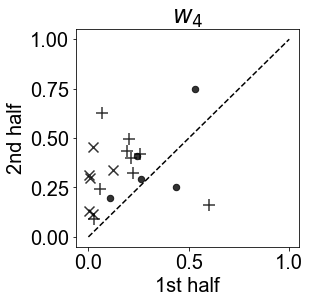

In [14]:
fig, ax = plt.subplots(figsize=(4,4))
for dataset in datasets:
    sns.regplot(x='half1', y='half2', data=df_w4[df_w4['rat'].isin(dataset2rat[dataset])], 
                color='k', fit_reg=False, marker=dataset2marker[dataset], scatter_kws={'s':100*ratio_s[dataset]}, label=dataset_labels[dataset])
ax.plot([0,1], [0,1], 'k--')
ax.set(xlabel='1st half', ylabel='2nd half', title='$w_4$')
ax.set(xticks=[0,0.5,1])

### $w_4$ vs $\Delta$WAIC correlate

-0.5585695589252265 0.010471436382308309


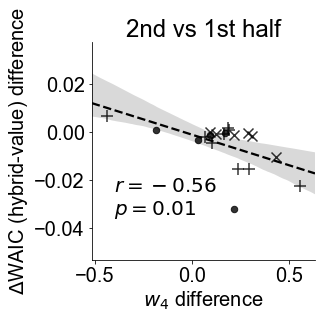

In [15]:
fig, ax = plt.subplots(figsize=(4,4))
r, p = pearsonr(df_w4['diff'], df_waic['diff'])
for dataset in datasets:
    sns.regplot(x=df_w4.loc[df_w4['rat'].isin(dataset2rat[dataset]), 'diff'], y=df_waic.loc[df_waic['rat'].isin(dataset2rat[dataset]), 'diff'],
                color='k', fit_reg=False, marker=dataset2marker[dataset], scatter_kws={'s':100*ratio_s[dataset]}, label=dataset_labels[dataset])
sns.regplot(x=df_w4['diff'], y=df_waic['diff'], color='k', fit_reg=p<.05, line_kws={'linestyle':'--'}, scatter=False)    
ax.set(xlabel='$w_4$ difference', ylabel='$\Delta$WAIC (hybrid-value) difference', title='2nd vs 1st half')
ax.text(x=-0.4, y=-0.035, s='$r='+str(np.round(r,2))+'$\n$p='+str(np.round(p,3))+'$')
sns.despine()
print(r, p)

## Explore potential predictors for learning effect

In [16]:
df = pd.DataFrame()
df['rat'] = ratList
df['w4'] = df_w4['diff']
df['waic'] = df_waic['diff']
df['rewardAmountAvg'] = pd.concat([data1, data2]).groupby('rat').mean()['rewardAmount'].values
df['n_sessions_total'] = pd.concat([data1, data2]).groupby('rat').nunique()['session'].values

In [17]:
predictors = ['rewardAmountAvg', 'n_sessions_total']
predictor_label = {
    'rewardAmountAvg': 'Avg reward',
    'n_sessions_total': '# sessions'
}

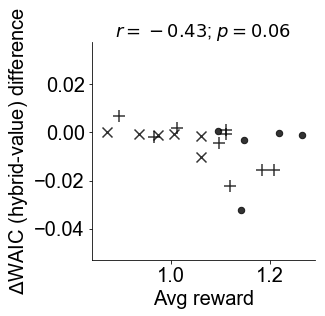

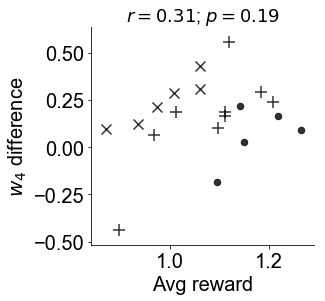

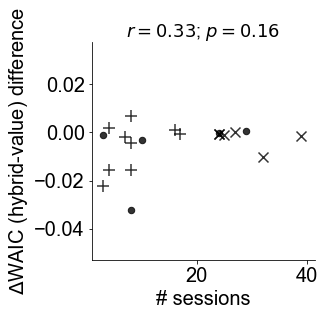

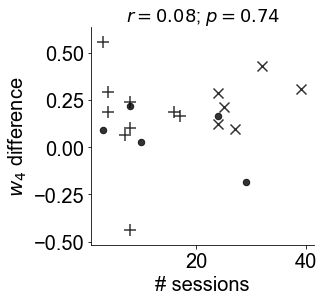

In [18]:
for predictor in predictors:
    for var in ['waic', 'w4']:
        fig, ax = plt.subplots(figsize=(4,4))
        r,p = pearsonr(df[predictor], df[var])
        for dataset in datasets:
            sns.regplot(x=predictor, y=var, data=df[df['rat'].isin(dataset2rat[dataset])], 
                        color='k', fit_reg=False, marker=dataset2marker[dataset], scatter_kws={'s':100*ratio_s[dataset]}, label=dataset_labels[dataset]);
        ax.set(xlabel=predictor_label[predictor], ylabel='$w_4$ difference' if var=='w4' else '$\Delta$WAIC (hybrid-value) difference')
        ax.set_title('$r='+str(np.round(r,2))+'$; $p='+str(np.round(p,2))+'$', fontsize=18)
        sns.despine()